In [40]:
#!pip install pyyaml h5py  # Required to save models in HDF5 format

In [1]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.4.1


In [42]:
#There are several methods to process data using Google Colab. 
#One of them is to simply upload the data to your Google drive.
#I used the cats/dogs dataset that is available on Kaggle/ other places (just google cats/dogs dataset).

#Step 1:

#Mount your drive- run the code, go to the link, accept (make sure you're choosing the user that has the data on his drive if you have several accounts).
#from google.colab import drive
#drive.mount('/content/gdrive')

In [61]:
#Step 2:

#Change the working directory to make it easier to access the files.
#The way I organized it is as follows:
#Inside the Colab folder in the drive- CNN folder- Images folder- Train/Test folders- inside of each there are the images) 

import os
os.chdir("D:/DCBdogs-vs-cats1000")
os.getcwd() 

'D:\\DCBdogs-vs-cats1000'

In [62]:
#You can do anything you want with the data after step 2. I will continue here to show my steps to create the simple CNN model.

# Import libraries
from __future__ import print_function, division

import numpy as np
import random
import os
import glob
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv

#from scipy.misc import imresize, imsave

from sklearn.metrics import log_loss, confusion_matrix
from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold
from PIL import Image, ImageChops, ImageOps

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, model_from_json
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense, BatchNormalization
#Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
# use ImageDataGenerator to preprocess the data
from keras.preprocessing.image import ImageDataGenerator

In [63]:
#Giving labels to the images: 1 for dog, 0 for cat

path = "D:/DCBdogs-vs-cats1000/train/"
files = os.listdir(path)
categories = []

for filename in files:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    elif category == 'cat':
        categories.append(0)
    else: pass
df = pd.DataFrame({
    'filename': files,
    'category': categories
})

<AxesSubplot:>

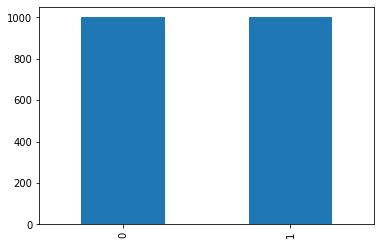

In [64]:
#Bar chart for the categories
df['category'].value_counts().plot.bar()

In [65]:
df


,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.101.jpg,0
...,...,...
1995,dog.995.jpg,1
1996,dog.996.jpg,1
1997,dog.997.jpg,1
1998,dog.998.jpg,1


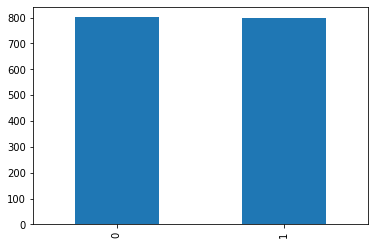

In [66]:
#Prepare Test and Train Data

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()

total_train = train_df.shape[0] #the number of images in the training df
total_validate = validate_df.shape[0]  #the number of images in the validate df
batch_size=32

In [67]:
IMAGE_WIDTH=96
IMAGE_HEIGHT=96
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB color

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 45, 45, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 30976)            

In [68]:
train_df["category"]=train_df["category"].astype(str)
validate_df["category"]=validate_df["category"].astype(str)

In [69]:
#Traning Generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "D:/DCBdogs-vs-cats1000/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 1600 validated image filenames belonging to 2 classes.


In [70]:
#Validation Generator

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "D:/DCBdogs-vs-cats1000/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 400 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


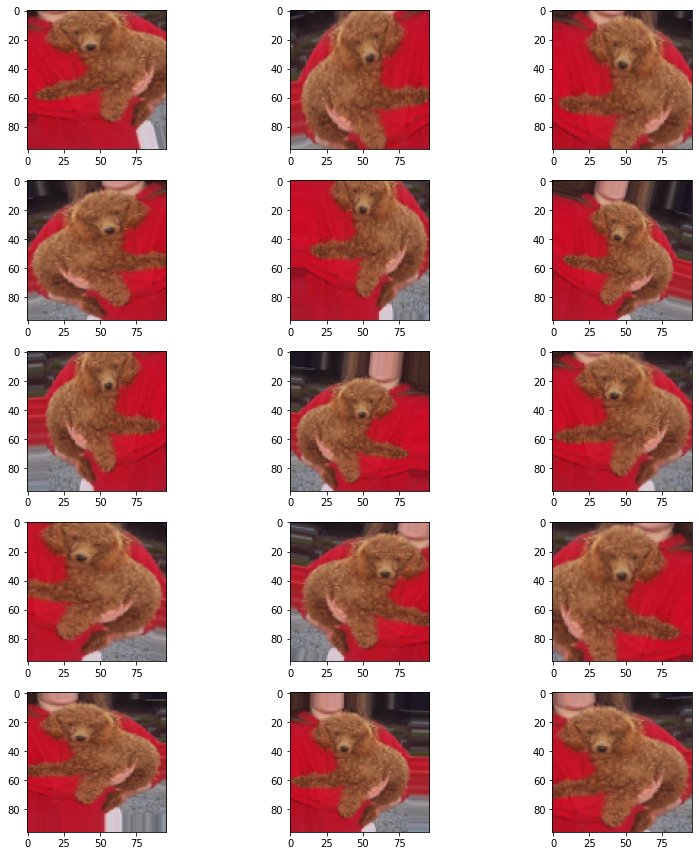

In [71]:
#See how the generator work

example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "D:/DCBdogs-vs-cats1000/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    #class_mode='binary'
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

<AxesSubplot:>

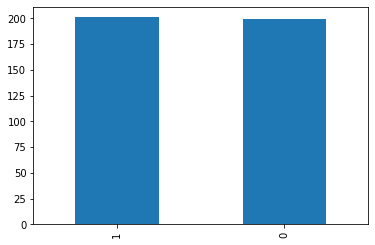

In [72]:
validate_df['category'].value_counts().plot.bar()

In [73]:
#Early Stopping 

earlystop = EarlyStopping(patience=10)

#Learning Rate Reduction

#We will reduce the learning rate when then accuracy is not increasing for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [74]:
#Fit Model

history = model.fit_generator(
    train_generator, 
    epochs=30,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/30
50/50 [==============================] - 33s 653ms/step - loss: 3.0165 - accuracy: 0.5619 - val_loss: 1.7227 - val_accuracy: 0.5078
Epoch 2/30
50/50 [==============================] - 33s 655ms/step - loss: 0.7277 - accuracy: 0.5825 - val_loss: 2.1432 - val_accuracy: 0.5339
Epoch 3/30
50/50 [==============================] - 33s 657ms/step - loss: 0.6708 - accuracy: 0.6300 - val_loss: 1.8684 - val_accuracy: 0.5833
Epoch 4/30
50/50 [==============================] - 33s 656ms/step - loss: 0.6887 - accuracy: 0.6225 - val_loss: 4.2715 - val_accuracy: 0.4948
Epoch 5/30
50/50 [==============================] - 33s 654ms/step - loss: 0.6312 - accuracy: 0.6288 - val_loss: 4.2816 - val_accuracy: 0.5547
Epoch 6/30
50/50 [==============================] - 33s 654ms/step - loss: 0.6415 - accuracy: 0.6450 - val_loss: 5.0858 - val_accuracy: 0.4922
Epoch 7/30
50/50 [==============================] - 33s 655ms/step - loss: 0.6247 - accuracy: 0.6481 - val_loss: 1.9654 - val_accuracy: 0.5391

Epoch 22/30
50/50 [==============================] - 33s 660ms/step - loss: 0.5588 - accuracy: 0.7125 - val_loss: 0.5367 - val_accuracy: 0.7344
Epoch 23/30
50/50 [==============================] - 33s 657ms/step - loss: 0.5378 - accuracy: 0.7294 - val_loss: 0.6036 - val_accuracy: 0.6797
Epoch 24/30
50/50 [==============================] - 33s 659ms/step - loss: 0.5338 - accuracy: 0.7306 - val_loss: 0.5337 - val_accuracy: 0.7318
Epoch 25/30
50/50 [==============================] - 37s 745ms/step - loss: 0.5148 - accuracy: 0.7325 - val_loss: 0.7474 - val_accuracy: 0.6172
Epoch 26/30
50/50 [==============================] - 42s 847ms/step - loss: 0.5429 - accuracy: 0.7281 - val_loss: 0.5702 - val_accuracy: 0.7083
Epoch 27/30
50/50 [==============================] - 41s 821ms/step - loss: 0.5314 - accuracy: 0.7169 - val_loss: 0.9380 - val_accuracy: 0.6849
Epoch 28/30
50/50 [==============================] - 32s 643ms/step - loss: 0.5145 - accuracy: 0.7475 - val_loss: 0.5591 - val_accuracy:

In [18]:
#Save Model (if you're happy with it)
# Save the weights
model.save_weights('model_weights_29.30.2020.h5')
model.save('dog_at.h5')# i have inserted this code



In [19]:
# Downloading in local disk
#from google.colab import files
#files.download("model_weights.h5")

# Save the model architecture
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [20]:
#Virtualize Training

#fig, ax = plt.subplots(2,1)
#ax[0].plot(history.history['loss'], color='b', label="Training loss")
#ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
#legend = ax[0].legend(loc='best', shadow=True)

#ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
#ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
#legend = ax[1].legend(loc='best', shadow=True)

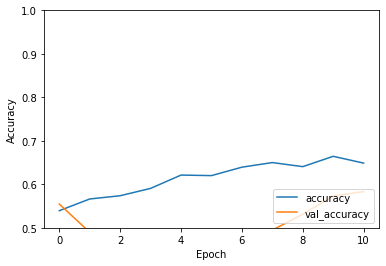

In [60]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.legend(loc='lower right')

In [54]:
epochs=5
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']


In [55]:
loss=history.history['loss']
val_loss=history.history['val_loss']

In [56]:
epochs_range=range(epochs)

ValueError: x and y must have same first dimension, but have shapes (5,) and (30,)

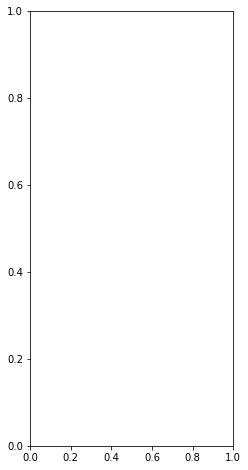

In [58]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Trainig Accuracy')
plt.plot(epochs_range, val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and validattion Accuracy')

ValueError: x and y must have same first dimension, but have shapes (5,) and (30,)

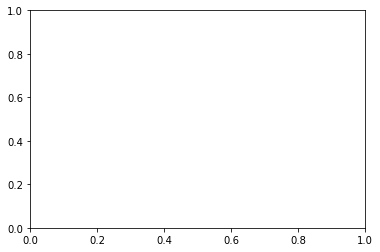

In [80]:
#plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [68]:
import cv2
def image_resizing(img_file):
  img_as_array=img_file
  #resized=cv2.resize(img_as_array),(img_width,img_height)
  resized=cv2.resize(img,(96,96))
  an_img=resized.reshape((1,)+resized.shape)
  return an_img


In [76]:
from  PIL import Image
img=np.asarray(Image.open('D:/DCBdogs-vs-cats1000/test/098.jpeg'))
img_rz=image_resizing(img)
img_rz.shape

(1, 96, 96, 3)

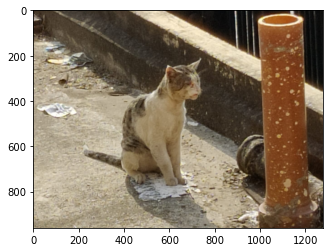

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img)


In [78]:
predictions=model.predict(img_rz)
score=predictions[0]
score


array([1.], dtype=float32)

In [79]:
print(
    "This image is %.2f percent cat %.2f percent dog."
    %(100*(1-score),100*score)
    
)

This image is 0.00 percent cat 100.00 percent dog.
